In [1]:
%matplotlib inline
import os 
from collections import deque
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import editdistance
import sys
import RNA
from typing import Dict, List, Tuple

import torch
from torch import nn
from tqdm import tqdm_notebook as tqdm
import torch.nn.functional as F
import torch.multiprocessing as mp
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_

# import path 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils.sequence_utils import translate_one_hot_to_string,generate_random_mutant
from models.Theoretical_models import *
from models.Noise_wrapper import *
from exploration_strategies.CE import *
from utils.landscape_utils import *
from models.RNA_landscapes import *
from models.Multi_dimensional_model import *

from segment_tree import MinSegmentTree, SumSegmentTree

Using TensorFlow backend.


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
RAA="UGCA" #alphabet
length=40

In [4]:
wt=generate_random_sequences(length,1,alphabet=RAA)[0]
wt

'AUCAACGAGCGCCAAGGUUCUGCCUAUUCGACCGUUGUUC'

In [5]:
#make a simple folding landscape starting at wt
landscape1=RNA_landscape(wt)

In [6]:
noise_alpha=1
experiment_batch_size=10
virtual_per_measure_ratio=15
temperature=0.1
generations=10

In [7]:
# there are multiple abstract "noise models" you can use, or you can try to train your own model, using skM
noisy_landscape=Noise_wrapper(landscape1,
                              noise_alpha=noise_alpha,
                              always_costly=True)

In [8]:
initial_genotypes=list(set([wt]+[generate_random_mutant(wt,0.05,RAA) for i in range(experiment_batch_size*10)]))[:experiment_batch_size]
len(initial_genotypes)

10

In [9]:
noisy_landscape.reset()
noisy_landscape.measure_true_landscape(initial_genotypes)
noisy_landscape.natural_mode=False
noisy_landscape.local_mode=False
noisy_landscape.cost

10

In [10]:
import numpy as np
import random
import bisect
from utils.sequence_utils import translate_string_to_one_hot, translate_one_hot_to_string

def renormalize_moves(one_hot_input, rewards_output):
    """ensures that staying in place gives no reward"""
    zero_current_state = (one_hot_input - 1) * (-1)
    return np.multiply(rewards_output, zero_current_state)

def walk_away_renormalize_moves(one_hot_input, one_hot_wt, rewards_output):
    """ensures that moving toward wt is also not useful"""
    zero_current_state=(one_hot_input-1)*-1
    zero_wt=((one_hot_wt-1)*-1)
    zero_conservative_moves=np.multiply(zero_wt,zero_current_state)
    return np.multiply(rewards_output,zero_conservative_moves)

def get_all_singles_fitness(model,sequence,alphabet):
    prob_singles=np.zeros((len(alphabet),len(sequence)))
    for i in range(len(sequence)):
        for j in range(len(alphabet)):
            putative_seq=sequence[:i]+alphabet[j]+sequence[i+1:]
           # print (putative_seq)
            prob_singles[j][i]=model.get_fitness(putative_seq)
    return prob_singles

def get_all_mutants(sequence):
    mutants = []
    for i in range(sequence.shape[0]):
        for j in range(sequence.shape[1]):
            putative_seq = sequence.copy()
            putative_seq[:, j] = 0
            putative_seq[i, j] = 1
            mutants.append(putative_seq)
    return np.array(mutants)

def sample_greedy(matrix):
    i,j=matrix.shape
    max_arg=np.argmax(matrix)
    y=max_arg%j
    x=int(max_arg/j)
    output=np.zeros((i,j))
    output[x][y]=matrix[x][y]
    return output

def sample_multi_greedy(matrix):
    n = 5 # the number of base positions to greedily change
    max_args = np.argpartition(matrix.flatten(), -n)[-n:]
    i,j=matrix.shape
    output=np.zeros((i,j))
    for max_arg in max_args:
        y=max_arg%j
        x=int(max_arg/j)
        output[x][y]=matrix[x][y]
    return output

def sample_random(matrix):
    i,j=matrix.shape
    non_zero_moves=np.nonzero(matrix)
   # print (non_zero_moves)
    k=len(non_zero_moves)
    l=len(non_zero_moves[0])
    if k!=0 and l!=0:
        rand_arg=random.choice([[non_zero_moves[alph][pos] for alph in range(k)] for pos in range(l)])
    else:
        rand_arg=[random.randint(0,i-1),random.randint(0,j-1)]
    #print (rand_arg)
    y=rand_arg[1]
    x=rand_arg[0]
    output=np.zeros((i,j))
    output[x][y] = 1
    return output   

def action_to_scalar(matrix):
    matrix = matrix.ravel()
    for i in range(len(matrix)):
        if matrix[i] != 0:
            return i
    
def construct_mutant_from_sample(pwm_sample, one_hot_base):
    one_hot = np.zeros(one_hot_base.shape)
    one_hot += one_hot_base
    nonzero = np.nonzero(pwm_sample)
    nonzero = list(zip(nonzero[0], nonzero[1]))
    for nz in nonzero: # this can be problematic for non-positive fitnesses
        i, j = nz
        one_hot[:,j]=0
        one_hot[i,j]=1
    return one_hot

def best_predicted_new_gen(actor, genotypes, alphabet, pop_size):
    mutants = get_all_mutants(genotypes)
    one_hot_mutants = np.array([translate_string_to_one_hot(mutant, alphabet) for mutant in mutants])
    torch_one_hot_mutants = torch.from_numpy(np.expand_dims(one_hot_mutants, axis=0)).float()
    predictions = actor(torch_one_hot_mutants)
    predictions = predictions.detach().numpy()
    best_pred_ind = predictions.argsort()[-pop_size:]
    return mutants[best_pred_ind]

def make_one_hot_train_test(genotypes, model, alphabet):
    genotypes_one_hot = np.array([translate_string_to_one_hot(genotype, alphabet) for genotype in genotypes])
    genotype_fitnesses = []
    for genotype in genotypes:
        genotype_fitnesses.append(model.get_fitness(genotype))
    genotype_fitnesses = np.array(genotype_fitnesses)

    return genotypes_one_hot, genotype_fitnesses

## Model

In [11]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, size: int, batch_size: int = 128):
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray
    ):
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs_buf[idxs],
                    next_obs=self.next_obs_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs])

    def __len__(self) -> int:
        return self.size

In [12]:
class PrioritizedReplayBuffer(ReplayBuffer):
    """Prioritized Replay buffer.
    
    Attributes:
        max_priority (float): max priority
        tree_ptr (int): next index of tree
        alpha (float): alpha parameter for prioritized replay buffer
        sum_tree (SumSegmentTree): sum tree for prior
        min_tree (MinSegmentTree): min tree for min prior to get max weight
        
    """
    
    def __init__(
        self, 
        obs_dim: int,
        size: int, 
        batch_size: int = 32, 
        alpha: float = 0.6
    ):
        """Initialization."""
        assert alpha >= 0
        
        super(PrioritizedReplayBuffer, self).__init__(obs_dim, size, batch_size)
        self.max_priority, self.tree_ptr = 1.0, 0
        self.alpha = alpha
        
        # capacity must be positive and a power of 2.
        tree_capacity = 1
        while tree_capacity < self.max_size:
            tree_capacity *= 2

        self.sum_tree = SumSegmentTree(tree_capacity)
        self.min_tree = MinSegmentTree(tree_capacity)
        
    def store(
        self, 
        obs: np.ndarray, 
        act: int, 
        rew: float, 
        next_obs: np.ndarray
    ):
        """Store experience and priority."""
        super().store(obs, act, rew, next_obs)
        
        self.sum_tree[self.tree_ptr] = self.max_priority ** self.alpha
        self.min_tree[self.tree_ptr] = self.max_priority ** self.alpha
        self.tree_ptr = (self.tree_ptr + 1) % self.max_size

    def sample_batch(self, beta: float = 0.4) -> Dict[str, np.ndarray]:
        """Sample a batch of experiences."""
        assert len(self) >= self.batch_size
        assert beta > 0
        
        indices = self._sample_proportional()
        
        obs = self.obs_buf[indices]
        next_obs = self.next_obs_buf[indices]
        acts = self.acts_buf[indices]
        rews = self.rews_buf[indices]
        weights = np.array([self._calculate_weight(i, beta) for i in indices])
        
        return dict(
            obs=obs,
            next_obs=next_obs,
            acts=acts,
            rews=rews,

            weights=weights,
            indices=indices,
        )
        
    def update_priorities(self, indices: List[int], priorities: np.ndarray):
        """Update priorities of sampled transitions."""
        assert len(indices) == len(priorities)

        for idx, priority in zip(indices, priorities):
            assert priority > 0
            assert 0 <= idx < len(self)

            self.sum_tree[idx] = priority ** self.alpha
            self.min_tree[idx] = priority ** self.alpha

            self.max_priority = max(self.max_priority, priority)
            
    def _sample_proportional(self) -> List[int]:
        """Sample indices based on proportions."""
        indices = []
        p_total = self.sum_tree.sum(0, len(self) - 1)
        segment = p_total / self.batch_size
        
        for i in range(self.batch_size):
            a = segment * i
            b = segment * (i + 1)
            upperbound = random.uniform(a, b)
            idx = self.sum_tree.retrieve(upperbound)
            indices.append(idx)
            
        return indices
    
    def _calculate_weight(self, idx: int, beta: float):
        """Calculate the weight of the experience at idx."""
        # get max weight
        p_min = self.min_tree.min() / self.sum_tree.sum()
        max_weight = (p_min * len(self)) ** (-beta)
        
        # calculate weights
        p_sample = self.sum_tree[idx] / self.sum_tree.sum()
        weight = (p_sample * len(self)) ** (-beta)
        weight = weight / max_weight
        
        return weight

In [13]:
from collections import deque
# from utils.RL_utils import *
from utils.sequence_utils import translate_one_hot_to_string,generate_random_mutant
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Q_Network(nn.Module):
    def __init__(self, sequence_len, alphabet_len):
        super(Q_Network, self).__init__()
        self.sequence_len = sequence_len
        self.alphabet_len = alphabet_len
        self.linear1 = nn.Linear(2 * alphabet_len * sequence_len, alphabet_len * sequence_len)
        self.bn1 = nn.BatchNorm1d(alphabet_len * sequence_len)
        self.linear2 = nn.Linear(alphabet_len * sequence_len, sequence_len)
        self.bn2 = nn.BatchNorm1d(sequence_len)
        self.linear3 = nn.Linear(sequence_len, 1)
    
    def forward(self, x):
        x = self.bn1(F.relu(self.linear1(x)))
        x = self.bn2(F.relu(self.linear2(x)))
        x = F.relu(self.linear3(x))
        return x
    
def build_q_network(sequence_len, alphabet_len, device):
    model = Q_Network(sequence_len, alphabet_len).to(device)
    print(model)
    return model


class RL_agent_DQN():
    '''
    Based off https://colab.research.google.com/drive/1NsbSPn6jOcaJB_mp9TmkgQX7UrRIrTi0
    '''
    def __init__(self, landscape, start_sequence, alphabet, gamma=0.9, 
                 memory_size=100000, batch_size=10, experiment_batch_size=10,
                 device = "cpu", noise_alpha=1):
        self.alphabet = alphabet
        self.alphabet_size = len(alphabet)
        self.state = translate_string_to_one_hot(start_sequence, self.alphabet)
        self.seq_size = len(start_sequence)
        self.q_network = build_q_network(self.seq_size, len(self.alphabet), device)
        self.q_network.eval()
        self.start_sequence = translate_string_to_one_hot(start_sequence,self.alphabet)
        self.memory_size = memory_size
        self.gamma = gamma
        self.batch_size = batch_size
        self.experiment_batch_size = experiment_batch_size
        self.memory = PrioritizedReplayBuffer(len(self.alphabet) * self.seq_size, 
                                              memory_size, batch_size, 0.6)
        self.seen_sequences = []
        self.landscape = landscape
        self.best_fitness = 0
        
        self.train_epochs = 10
        self.epsilon_min = 0.1
        
        self.top_sequence = []

    def reset_position(self,sequence):
        self.state=translate_string_to_one_hot(sequence,self.alphabet)

    def get_position(self):
        return translate_one_hot_to_string(self.state,self.alphabet)

    def translate_pwm_to_sequence(self,input_seq_one_hot,output_pwm):
        diff=output_pwm-input_seq_one_hot
        most_likely=np.argmax(diff,axis=0)
        out_seq=""
        for m in most_likely:
            out_seq+=self.alphabet[m]
        return out_seq
    
    def sample(self):
        indices = np.random.choice(len(self.memory), self.batch_size)
        rewards, actions, states, next_states = zip(*[self.memory[ind] for ind in indices])
        return np.array(rewards), np.array(actions), np.array(states), np.array(next_states) 
    
    def calculate_next_q_values(self, state_v):
        dim = self.alphabet_size * self.seq_size
        states_repeated = state_v.repeat(1, dim).reshape(-1, dim)
        actions_repeated = torch.FloatTensor(np.identity(dim)).repeat(len(state_v), 1)
        next_states_actions = torch.cat((states_repeated, actions_repeated), 1)
        next_states_values = self.q_network(next_states_actions)
        next_states_values = next_states_values.reshape(len(state_v), -1)
        
        return next_states_values
    
    def q_network_loss(self, batch, device="cpu"):
        """
        Calculate MSE between actual state action values,
        and expected state action values from DQN
        """
        rewards, actions, states, next_states = \
        batch['rews'], batch['acts'], batch['obs'], batch['next_obs']
        
        state_action_v = torch.FloatTensor(np.hstack((states, actions)))
        rewards_v = torch.FloatTensor(rewards)
        next_states_v = torch.FloatTensor(next_states)
    
        state_action_values = self.q_network(state_action_v).view(-1)
        next_state_values = self.calculate_next_q_values(next_states_v)
        next_state_values = next_state_values.max(1)[0].detach()
        expected_state_action_values = next_state_values * self.gamma + rewards_v
        
        return nn.MSELoss()(state_action_values, expected_state_action_values)

    def train_actor(self, train_epochs=10):
        total_loss = 0.
        # train Q network on new samples 
        optimizer = optim.Adam(self.q_network.parameters())
        for epoch in range(train_epochs):
            batch = self.memory.sample_batch()
            optimizer.zero_grad()
            loss = self.q_network_loss(batch)
            loss.backward()
            clip_grad_norm_(self.q_network.parameters(), 1.0, norm_type=1)
            optimizer.step()
            total_loss += loss.item()
        return (total_loss / train_epochs)

    def get_action_and_mutant(self, sample, epsilon):
        sample_tensor = torch.FloatTensor([sample.ravel()])
        prediction = self.calculate_next_q_values(sample_tensor).detach().numpy()
        prediction = prediction.reshape((len(self.alphabet), self.seq_size))
        # make action
        moves = renormalize_moves(sample, prediction)
        p = random.random()
        action = sample_random(moves) if p < epsilon else sample_greedy(moves)
        predicted_reward = (moves * action).sum()
        # get next state (mutant)
        mutant = construct_mutant_from_sample(action, sample)
        mutant_string = translate_one_hot_to_string(mutant, self.alphabet)

        return action, mutant, predicted_reward
    
    def rollout(self, sample, epsilon, steps=5):
        results = []
        mutant = sample.copy()
        for _ in range(steps):
            prev_mutant = mutant.copy()
            action, mutant, predicted_reward = self.get_action_and_mutant(mutant, epsilon)
            results.append((prev_mutant, action, mutant, predicted_reward))
        return results
    
    def initialize_actor_network(self):
        # initialization of actor network with randomly selected samples 
        samples = generate_random_sequences(length, self.experiment_batch_size, alphabet=RAA)
        samples = np.array([translate_string_to_one_hot(state_string, self.alphabet) 
                                    for state_string in samples])
        for i in range(self.experiment_batch_size):
            state = samples[i]
            action, new_state, _ = self.get_action_and_mutant(state, 0.5)
            new_state_string = translate_one_hot_to_string(new_state, self.alphabet)
            actual_reward = self.landscape.get_fitness(new_state_string)
            self.memory.store(state.ravel(), action.ravel(), actual_reward, new_state.ravel())
        avg_loss = self.train_actor(self.train_epochs)
        print('Initialization of actor network finished...')
        return samples
        
    def pick_action(self, samples):
        eps = max(self.epsilon_min, (0.5 - self.landscape.cost / (self.experiment_batch_size * generations)))
        b = 0
        new_samples = []
        costs, fitnesses = [], []
        # perform rollout procedure to prepare next batch used in experimentation 
        for i in range(self.experiment_batch_size):
            rollout_results = self.rollout(samples[i], eps)
            new_samples.extend(rollout_results)
        new_samples = sorted(new_samples, key = lambda x: x[3])[-self.experiment_batch_size:]
#         print(len(set([translate_one_hot_to_string(sample[2], self.alphabet) for sample in new_samples])))
        # evaluate next batch 
        for i in range(self.experiment_batch_size):
            state, action, new_state, _ = new_samples[i]
            new_state_string = translate_one_hot_to_string(new_state, self.alphabet)
            actual_reward = self.landscape.get_fitness(new_state_string)
            if not new_state_string in self.landscape.measured_sequences:
                if actual_reward > self.best_fitness:
                    state_tensor = torch.FloatTensor([state.ravel()])
                    prediction = self.calculate_next_q_values(state_tensor).detach().numpy()
                    prediction = prediction.reshape((len(self.alphabet), self.seq_size))
                    #print(prediction)
                    self.top_sequence.append((actual_reward, new_state, self.landscape.cost))
                self.best_fitness = max(self.best_fitness, actual_reward)
                self.memory.store(state.ravel(), action.ravel(), actual_reward, new_state.ravel())
        # set new set of samples to be evaluated in next iterations of loop
        samples = [sample[2] for sample in new_samples] 
        #print([translate_one_hot_to_string(sample, self.alphabet) for sample in samples])
        avg_loss = self.train_actor(self.train_epochs)
        costs.append(self.landscape.cost)
        fitnesses.append(self.best_fitness)
        return samples

In [31]:
agent = RL_agent_DQN(landscape=noisy_landscape, start_sequence=wt,
                     alphabet=RAA, gamma=0.8, memory_size=10000,
                     device=device, experiment_batch_size=experiment_batch_size)

noisy_landscape.reset()
noisy_landscape.measure_true_landscape(initial_genotypes)
noisy_landscape.natural_mode=False
noisy_landscape.local_mode=False
noisy_landscape.cost

samples = agent.initialize_actor_network()
while noisy_landscape.cost < generations*experiment_batch_size:
    samples = agent.pick_action(samples)
    print(f"Cost: {noisy_landscape.cost}, Top fitness: {agent.top_sequence[-1][0]}")

Q_Network(
  (linear1): Linear(in_features=320, out_features=160, bias=True)
  (bn1): BatchNorm1d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=160, out_features=40, bias=True)
  (bn2): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=40, out_features=1, bias=True)
)
Initialization of actor network finished...
Cost: 30, Top fitness: 0.16117646834429572
Cost: 39, Top fitness: 0.16823529636158663
Cost: 46, Top fitness: 0.16823529636158663
Cost: 50, Top fitness: 0.16823529636158663
Cost: 54, Top fitness: 0.16823529636158663
Cost: 64, Top fitness: 0.16823529636158663
Cost: 74, Top fitness: 0.1929411719827091
Cost: 83, Top fitness: 0.1929411719827091
Cost: 90, Top fitness: 0.1929411719827091
Cost: 97, Top fitness: 0.1929411719827091
Cost: 104, Top fitness: 0.1929411719827091


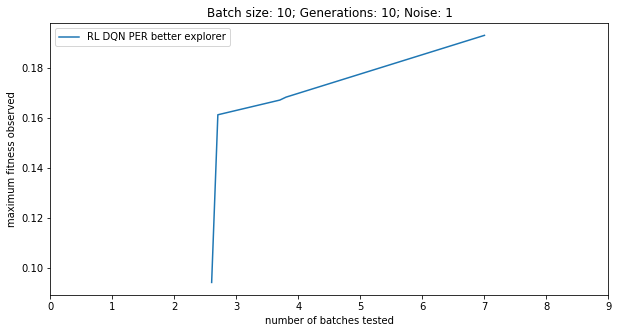

In [32]:
plt.figure(figsize=(10,5))
#plt.xscale("log")
plt.title(f"Batch size: {experiment_batch_size}; Generations: {generations}; Noise: {noise_alpha}")
plt.xlabel("number of batches tested")
plt.ylabel("maximum fitness observed")
plt.plot([t[2]/experiment_batch_size for t in agent.top_sequence[1:]],[t[0] for t in agent.top_sequence[1:]],label="RL DQN PER better explorer")

plt.legend()
plt.xticks(range(generations));

In [15]:
agent = RL_agent_DQN(landscape=noisy_landscape, start_sequence=wt,
                     alphabet=RAA, gamma=0, memory_size=10000,
                     device=device, experiment_batch_size=experiment_batch_size)

noisy_landscape.reset()
noisy_landscape.measure_true_landscape(initial_genotypes)
noisy_landscape.natural_mode=False
noisy_landscape.local_mode=False
noisy_landscape.cost

samples = agent.initialize_actor_network()
while noisy_landscape.cost < generations*experiment_batch_size:
    samples = agent.pick_action(samples)
    print(f"Cost: {noisy_landscape.cost}, Top fitness: {agent.top_sequence[-1][0]}")

Q_Network(
  (linear1): Linear(in_features=320, out_features=160, bias=True)
  (bn1): BatchNorm1d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=160, out_features=40, bias=True)
  (bn2): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=40, out_features=1, bias=True)
)
Initialization of actor network finished...
Cost: 22, Top fitness: 0.16000000448787913
Cost: 24, Top fitness: 0.16000000448787913
Cost: 25, Top fitness: 0.16000000448787913
Cost: 29, Top fitness: 0.18235294117647058
Cost: 31, Top fitness: 0.18235294117647058
Cost: 32, Top fitness: 0.18235294117647058
Cost: 33, Top fitness: 0.18235294117647058
Cost: 33, Top fitness: 0.18235294117647058
Cost: 35, Top fitness: 0.18235294117647058
Cost: 35, Top fitness: 0.18235294117647058
Cost: 36, Top fitness: 0.18235294117647058
Cost: 38, Top fitness: 0.18235294117647058
Cost: 38, Top fitness: 0.18235294117647058
Cost: 38, T